# HW2 - Word2Vec
## First Notebook
### Mathilde Kretz

In [1]:
%%capture
!pip install transformers datasets

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tabulate import tabulate
from datasets import load_dataset

from tqdm.notebook import tqdm
from transformers import BertTokenizer

# If the machine you run this on has a GPU available with CUDA installed,
# use it. Using a GPU for learning often leads to huge speedups in training.
# See https://developer.nvidia.com/cuda-downloads for installing CUDA
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

This is a template of the notebook that you should complete and enrich with your own code.

First cells will be the same than the ones of the lab on text convolution.

# Data loading


In [3]:
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})


# Pre-processing / Tokenization

This is a very important step. It maybe boring but very important. In this session we will be lazy, but in real life, the time spent on inspecting and cleaning data is never wasted. It is true for text, but also for everything.



In PyTorch, everything is tensor. Words are replaced by indices. A sentence, is therefore a sequence of indices (long integers). In the first HW, you constructed a `WhiteSpaceTokenizer`. Here we will use an already built tokenizer. It is more appropriate to transformers. It relies on sub-word units, and converts everything in lower case. This is not always the best choice, but here it will be sufficient. To quote the documentation, this tokenizer allows you to:
- Tokenize (splitting strings in sub-word token strings), converttokens strings to ids and back, and encoding/decoding (i.e., tokenizing and converting to integers).
- Add new tokens to the vocabulary in a way that is independent of the underlying structure (BPE, SentencePiece…).
- Manage special tokens (like mask, beginning-of-sentence, etc.): adding them, assigning them to attributes in the tokenizer for easy access and making sure they are not split during tokenization.

Here we are going to use the tokenizer from the well known Bert model, that we can directly download.

In [4]:
# global parameters
R = 4
K = 6

In [5]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)


In [6]:
def preprocessing_fn(x, tokenizer):
    x["review_ids"] = tokenizer(
        x["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding=False,
        return_attention_mask=False,
    )["input_ids"]
    x["label"] = 0 if x["sentiment"] == "negative" else 1
    return x


Same cell than in the lab session.


Read the documentation about HuggingFace dataset and complete the code below.
You should:
- Shuffle the dataset
- For computational reasons, use only a total of **5000 samples**.
- Tokenize the dataset with the `preprocessing_fn`. (*Hint: use the `Dataset.map` method from HuggingFace*).
- Keep only columns `review_ids` and `label`.
- Make a train/validation split, (**80% / 20%**). Call these dataset `train_set` and `valid_set`.


In [7]:
n_samples = 5000  # the number of training example for test
#n_samples = 10000 #yes i have time

# We first shuffle the data !
dataset = dataset.shuffle()

# Select 5000 samples
split_dataset = dataset.select(range(n_samples))

# Tokenize the dataset
tok_dataset = split_dataset.map(preprocessing_fn,
                                fn_kwargs={"tokenizer" : tokenizer})

# Remove useless columns
tok_dataset = tok_dataset.select_columns(["review_ids"])

# Split the train and validation
tok_dataset = tok_dataset.train_test_split(test_size = 0.2)

document_train_set = tok_dataset["train"]
document_valid_set = tok_dataset["test"]


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

##Context creation


Q.2 Extraction of positive context

In [8]:
def extract_words_contexts(document_ids_list, R):
    w_ids, pos_C_list = [], []
    for i in range(len(document_ids_list)) :
        w = document_ids_list[i]
        pos_C = [0 for i in range(2*R)] #the default value is 0 (corresponds to <PAD>) for 'outside borders tokens'
        for j in range(R) :
            m = R//2
            if i-j-1 >= 0 : #we are not outside the borders
                pos_C[m-j+1] = document_ids_list[i-j-1]
            if i+j+1 < len(document_ids_list) :
                pos_C[m+j+2] = document_ids_list[i+j+1]
        w_ids.append(w)
        pos_C_list.append(pos_C)
    return w_ids, pos_C_list

🔴 **TEST**

In [9]:
W,C = extract_words_contexts(document_train_set[0]['review_ids'], R)

print(W[0], C[0])
print(W[4], C[4])

2023 [0, 0, 0, 0, 2003, 2025, 1037, 2204]
2204 [2023, 2003, 2025, 1037, 3185, 1012, 2009, 1005]


Q.3 Extraction of positive context for the whole dataset

In [10]:
def flatten_dataset_to_list(dataset, R):
    W, C = [], [] #will contain global list returned by extract_words_context
    for ids_list in dataset["review_ids"]:
        wi,ci = extract_words_contexts(ids_list, R)
        W+= wi #concatenation of lists
        C+= ci
    return W, C

🔴 **TEST**

Q.4 Creation of flattened lists

In [11]:
train_W,train_pos_C = flatten_dataset_to_list(document_train_set, R)
valid_W,valid_pos_C = flatten_dataset_to_list(document_valid_set, R)

w,c = extract_words_contexts(document_train_set["review_ids"][0], R)
assert train_pos_C[0] == c[0]
assert len(train_pos_C) == len(train_W)
print("train size:", len(train_W))
print("validation size:", len(valid_W))

train size: 828483
validation size: 206593


###Dataset for PyTorch

Q.5 Dataset creation

In [12]:
from torch.utils.data import Dataset


class W2VDataset(Dataset):
    def __init__(self, w_list, pos_c_list):
        self.w_list = w_list
        self.pos_c_list = pos_c_list

    def __len__(self):
        return len(self.w_list)

    def __getitem__(self, idx: int):
        return self.w_list[idx], self.pos_c_list[idx]

🔴 **TEST**

In [13]:
train_set = W2VDataset(train_W, train_pos_C)
valid_set = W2VDataset(valid_W, valid_pos_C)

###DataLoader for PyTorch

Q.6 Implementation of the collate function

In [14]:
vocabulary_tokens = list(tokenizer.get_vocab().values())

def collate_fn(batch, K=K, R=R):
    word_id, positive_context_ids, negative_context_ids = [], [], []

    for i in range(len(batch)):
        w, pos_c = batch[i]
        neg_c = random.sample(vocabulary_tokens, 2*K*R)
        word_id.append(w)
        positive_context_ids.append(pos_c)
        negative_context_ids.append(neg_c)
    return {"word_id": torch.tensor(word_id), "positive_context_ids": torch.tensor(positive_context_ids), "negative_context_ids": torch.tensor(negative_context_ids)}

🔴 **TEST**

Q.7.8 Wrapping in Dataloader

In [15]:
from torch.utils.data import DataLoader

In [16]:
for batch_size in range(1, 4):
    dataloader = DataLoader(
        dataset=train_set, batch_size=batch_size, collate_fn=collate_fn
        )
    for batch in dataloader:
        word_id = batch["word_id"]
        positive_context_ids = batch["positive_context_ids"]
        negative_context_ids = batch["negative_context_ids"]
        print("R =", R, ", K =", K, ", batch_size = ", batch_size)
        print("word_id tensor dimension :", word_id.shape)
        print("positive_context_ids tensor dimension :", positive_context_ids.shape)
        print("negative_context_ids tensor dimension :", negative_context_ids.shape)
        break


#Dataloader for future tests
batch_size = 4

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=collate_fn
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=collate_fn
)

R = 4 , K = 6 , batch_size =  1
word_id tensor dimension : torch.Size([1])
positive_context_ids tensor dimension : torch.Size([1, 8])
negative_context_ids tensor dimension : torch.Size([1, 48])
R = 4 , K = 6 , batch_size =  2
word_id tensor dimension : torch.Size([2])
positive_context_ids tensor dimension : torch.Size([2, 8])
negative_context_ids tensor dimension : torch.Size([2, 48])
R = 4 , K = 6 , batch_size =  3
word_id tensor dimension : torch.Size([3])
positive_context_ids tensor dimension : torch.Size([3, 8])
negative_context_ids tensor dimension : torch.Size([3, 48])


# Model

Q9. Implementation of the Word2Vec model with a single layer of embedding.

In [17]:
class Word2Vec(nn.Module):

    def __init__(self, vocabulary_size, embedding_dimension):
        super().__init__()
        self.word_embedding = nn.Embedding(num_embeddings=vocabulary_size, embedding_dim=embedding_dimension)
        self.context_embedding = nn.Embedding(num_embeddings=vocabulary_size, embedding_dim=embedding_dimension)

    def forward(self, word, context) :
        word_embeds = self.word_embedding(word)
        context_embeds = self.context_embedding(context)
        similarity_score = torch.sigmoid(torch.sum(word_embeds * context_embeds, dim=2)) #sigmoid of the dot product
        return similarity_score


🔴**TEST**

In [18]:
#Model initilization
vocabulary_size = len(tokenizer.get_vocab())
embedding_dimension = 100
model = Word2Vec(vocabulary_size, embedding_dimension)


#Batch iteration for test
batch = next(iter(train_dataloader))
word_id = batch["word_id"]
positive_context_ids = batch["positive_context_ids"]
negative_context_ids = batch["negative_context_ids"]

#out_pos = model.forward(word_id, positive_context_ids[:,1])
#print(out_pos)
out_allpos = model.forward(word_id.unsqueeze(1),positive_context_ids)
#print(out_allpos, out_allpos.shape)
#out_neg = model.forward(word_id, negative_context_ids[:,1])


Q.10 Training of the model

In [19]:
def training(model, B, E, lr=5e-5):
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        eps=1e-08,
    )
    criterion = nn.BCELoss()

    list_val_acc = []
    list_train_acc = []
    list_train_loss = []
    list_val_loss = []

    #DataLoader of training and validation sets
    train_dataloader = DataLoader(
      train_set, batch_size=B, collate_fn=collate_fn
      )
    valid_dataloader = DataLoader(
      valid_set, batch_size=B, collate_fn=collate_fn
      )

    for e in range(E) :
        # ========== Training ==========

        # Set model to training mode
        model.train()
        model.to(DEVICE)

        # Tracking variables
        train_loss = 0
        epoch_train_acc = 0
        total_size = 0
        for batch in tqdm(train_dataloader):
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            word_id, positive_context_ids, negative_context_ids = (
                batch["word_id"],
                batch["positive_context_ids"],
                batch["negative_context_ids"],
            )

            #Forward pass
            optimizer.zero_grad()
            #print(word_id.shape, positive_context_ids.shape)
            out_positive = model.forward(word_id.unsqueeze(1),positive_context_ids) #similarity between all words of context, add the first dimension (ie nb of context) for word_id
            out_negative = model.forward(word_id.unsqueeze(1),negative_context_ids)
            positive_labels = torch.ones(out_positive.shape, device=DEVICE)
            negative_labels = torch.zeros(out_negative.shape, device = DEVICE)

            loss_positive = criterion(out_positive, positive_labels)
            loss_negative = criterion(out_negative, negative_labels)
            loss = loss_positive + loss_negative #mean of losses

            #Backward pass
            loss.backward()
            optimizer.step()
            acc_pos = (out_positive > 0.5)
            acc_neg = (out_negative < 0.5)
            total_size += acc_pos.shape[0]*acc_pos.shape[1] + acc_neg.shape[0]*acc_neg.shape[1]
            epoch_train_acc += acc_pos.sum().item()
            epoch_train_acc += acc_neg.sum().item()
            train_loss += loss.detach().cpu().item()
        list_train_acc.append(epoch_train_acc / total_size)
        list_train_loss.append(train_loss / len(train_dataloader))

        # ========== Validation ==========
        model.eval()
        valid_loss = 0
        valid_acc = 0
        total_size = 0
        with torch.no_grad():
            for batch in tqdm(valid_dataloader):
                batch = {k: v.to(DEVICE) for k, v in batch.items()}
                word_id, positive_context_ids, negative_context_ids = (
                    batch["word_id"],
                    batch["positive_context_ids"],
                    batch["negative_context_ids"],
                )
                preds_positive = model.forward(word_id.unsqueeze(1),positive_context_ids)
                preds_negative = model.forward(word_id.unsqueeze(1),negative_context_ids)
                positive_labels = torch.ones(preds_positive.shape, device=DEVICE)
                negative_labels = torch.zeros(preds_negative.shape, device = DEVICE)

                loss_positive = criterion(preds_positive, positive_labels)
                loss_negative = criterion(preds_negative, negative_labels)
                loss = loss_positive + loss_negative

                acc_pos = (preds_positive > 0.5)
                acc_neg = (preds_negative < 0.5)
                total_size += acc_pos.shape[0]*acc_pos.shape[1] + acc_neg.shape[0]*acc_neg.shape[1]
                valid_acc += acc_pos.sum().item() + acc_neg.sum().item()
                valid_loss += loss.item()
        total_valid_loss = valid_loss / len(valid_dataloader)
        total_valid_acc = valid_acc / total_size

        # ========== End of epoch ==========
        list_val_loss.append(total_valid_loss)
        list_val_acc.append(total_valid_acc)
        print(
            e,
            "\n\t - Train loss: {:.4f}".format(list_train_loss[-1]),
            "Train acc: {:.4f}".format(list_train_acc[-1]),
            "Val loss: {:.4f}".format(total_valid_loss),
            "Val acc:{:.4f}".format(total_valid_acc),
        )
    return list_train_loss, list_train_acc, list_val_loss, list_val_acc


In [20]:
batch_size = 32
nb_epochs = 35
list_train_loss, list_train_acc, list_val_loss, list_val_acc = training(model, B=batch_size, E=nb_epochs)

  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

0 
	 - Train loss: 9.9359 Train acc: 0.5117 Val loss: 8.3148 Val acc:0.5221


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

1 
	 - Train loss: 7.1199 Train acc: 0.5352 Val loss: 6.1150 Val acc:0.5505


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

2 
	 - Train loss: 5.3354 Train acc: 0.5732 Val loss: 4.6689 Val acc:0.5998


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

3 
	 - Train loss: 4.1115 Train acc: 0.6325 Val loss: 3.6649 Val acc:0.6660


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

4 
	 - Train loss: 3.2680 Train acc: 0.6965 Val loss: 2.9701 Val acc:0.7236


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

5 
	 - Train loss: 2.6803 Train acc: 0.7440 Val loss: 2.4815 Val acc:0.7617


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

6 
	 - Train loss: 2.2586 Train acc: 0.7757 Val loss: 2.1323 Val acc:0.7880


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

7 
	 - Train loss: 1.9482 Train acc: 0.7986 Val loss: 1.8668 Val acc:0.8078


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

8 
	 - Train loss: 1.7119 Train acc: 0.8160 Val loss: 1.6664 Val acc:0.8229


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

9 
	 - Train loss: 1.5288 Train acc: 0.8302 Val loss: 1.5062 Val acc:0.8354


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

10 
	 - Train loss: 1.3812 Train acc: 0.8417 Val loss: 1.3818 Val acc:0.8458


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

11 
	 - Train loss: 1.2626 Train acc: 0.8514 Val loss: 1.2764 Val acc:0.8547


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

12 
	 - Train loss: 1.1654 Train acc: 0.8596 Val loss: 1.1912 Val acc:0.8620


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

13 
	 - Train loss: 1.0860 Train acc: 0.8668 Val loss: 1.1207 Val acc:0.8684


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

14 
	 - Train loss: 1.0174 Train acc: 0.8730 Val loss: 1.0598 Val acc:0.8741


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

15 
	 - Train loss: 0.9599 Train acc: 0.8784 Val loss: 1.0081 Val acc:0.8791


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

16 
	 - Train loss: 0.9095 Train acc: 0.8833 Val loss: 0.9635 Val acc:0.8834


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

17 
	 - Train loss: 0.8657 Train acc: 0.8876 Val loss: 0.9254 Val acc:0.8871


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

18 
	 - Train loss: 0.8282 Train acc: 0.8914 Val loss: 0.8906 Val acc:0.8907


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

19 
	 - Train loss: 0.7945 Train acc: 0.8948 Val loss: 0.8601 Val acc:0.8940


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

20 
	 - Train loss: 0.7647 Train acc: 0.8979 Val loss: 0.8337 Val acc:0.8965


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

21 
	 - Train loss: 0.7382 Train acc: 0.9007 Val loss: 0.8091 Val acc:0.8991


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

22 
	 - Train loss: 0.7142 Train acc: 0.9032 Val loss: 0.7876 Val acc:0.9013


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

23 
	 - Train loss: 0.6927 Train acc: 0.9054 Val loss: 0.7676 Val acc:0.9032


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

24 
	 - Train loss: 0.6730 Train acc: 0.9075 Val loss: 0.7497 Val acc:0.9051


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

25 
	 - Train loss: 0.6549 Train acc: 0.9093 Val loss: 0.7329 Val acc:0.9068


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

26 
	 - Train loss: 0.6386 Train acc: 0.9110 Val loss: 0.7177 Val acc:0.9082


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

27 
	 - Train loss: 0.6235 Train acc: 0.9125 Val loss: 0.7030 Val acc:0.9096


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

28 
	 - Train loss: 0.6092 Train acc: 0.9138 Val loss: 0.6903 Val acc:0.9107


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

29 
	 - Train loss: 0.5962 Train acc: 0.9149 Val loss: 0.6782 Val acc:0.9117


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

30 
	 - Train loss: 0.5842 Train acc: 0.9159 Val loss: 0.6669 Val acc:0.9124


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

31 
	 - Train loss: 0.5730 Train acc: 0.9167 Val loss: 0.6560 Val acc:0.9131


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

32 
	 - Train loss: 0.5623 Train acc: 0.9174 Val loss: 0.6459 Val acc:0.9138


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

33 
	 - Train loss: 0.5524 Train acc: 0.9180 Val loss: 0.6367 Val acc:0.9143


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

34 
	 - Train loss: 0.5431 Train acc: 0.9186 Val loss: 0.6282 Val acc:0.9146


🔴 **TEST**

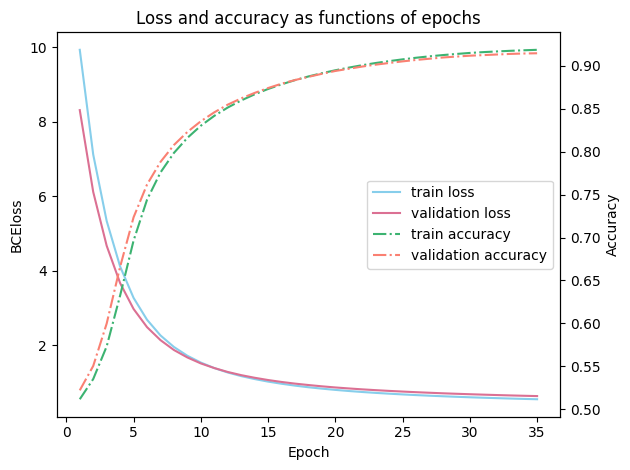

In [21]:
epoch = [i for i in range(1,nb_epochs+1)]

fig, axloss = plt.subplots()
axloss.plot(epoch, list_train_loss, label='train loss', color='skyblue')
axloss.plot(epoch, list_val_loss, label='validation loss', color='palevioletred')
axloss.set_xlabel('Epoch')
axloss.set_ylabel('BCEloss')

axacc = axloss.twinx()
axacc.plot(epoch, list_train_acc, label='train accuracy', color='mediumseagreen', linestyle='dashdot')
axacc.plot(epoch, list_val_acc, label='validation accuracy', color='salmon', linestyle='dashdot')
axacc.set_ylabel('Accuracy')

lines, labels = axloss.get_legend_handles_labels()
lines2, labels2 = axacc.get_legend_handles_labels()
axacc.legend(lines + lines2, labels + labels2, loc='center right')
plt.title('Loss and accuracy as functions of epochs')

fig.tight_layout()
plt.show()

Q.12 Saving of the checkpoints

In [22]:
def save_model(model, dimension=embedding_dimension, radius=R, ratio=K, batch=batch_size, epoch=nb_epochs):
    file_name = f"model_dim-{dimension}_radius-{radius}_ratio-{ratio}-batch-{batch}-epoch-{epoch}.ckpt"
    torch.save(model.state_dict(), file_name)

In [23]:
save_model(model, dimension=embedding_dimension, radius=R, ratio=K, batch=batch_size, epoch=nb_epochs)

Q.3.3.4 Comparison making on parameters (ablation study)

In [24]:
embedding_dimension = 200
K, R = 2, 3
batch_size = 32

train_W_comp,train_pos_C_comp = flatten_dataset_to_list(document_train_set, R)
valid_W_comp,valid_pos_C_comp = flatten_dataset_to_list(document_valid_set, R)
train_set_comp = W2VDataset(train_W_comp, train_pos_C_comp)
valid_set_comp = W2VDataset(valid_W_comp, valid_pos_C_comp)
model_comp = Word2Vec(vocabulary_size, embedding_dimension)
list_train_loss_comp, list_train_acc_comp, list_val_loss_comp, list_val_acc_comp = training(model_comp, B=batch_size, E=nb_epochs)
save_model(model_comp, dimension=embedding_dimension, radius=R, ratio=K, batch=batch_size, epoch=nb_epochs)

  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

0 
	 - Train loss: 17.7817 Train acc: 0.5168 Val loss: 15.8272 Val acc:0.5308


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

1 
	 - Train loss: 14.0877 Train acc: 0.5463 Val loss: 12.4409 Val acc:0.5636


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

2 
	 - Train loss: 10.9378 Train acc: 0.5850 Val loss: 9.5882 Val acc:0.6088


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

3 
	 - Train loss: 8.4464 Train acc: 0.6350 Val loss: 7.5273 Val acc:0.6611


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

4 
	 - Train loss: 6.6947 Train acc: 0.6866 Val loss: 6.0620 Val acc:0.7096


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

5 
	 - Train loss: 5.4443 Train acc: 0.7296 Val loss: 5.0329 Val acc:0.7467


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

6 
	 - Train loss: 4.5329 Train acc: 0.7617 Val loss: 4.2607 Val acc:0.7742


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

7 
	 - Train loss: 3.8443 Train acc: 0.7860 Val loss: 3.6590 Val acc:0.7953


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

8 
	 - Train loss: 3.3023 Train acc: 0.8049 Val loss: 3.1984 Val acc:0.8118


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

9 
	 - Train loss: 2.8804 Train acc: 0.8197 Val loss: 2.8259 Val acc:0.8251


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

10 
	 - Train loss: 2.5305 Train acc: 0.8319 Val loss: 2.5209 Val acc:0.8360


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

11 
	 - Train loss: 2.2461 Train acc: 0.8423 Val loss: 2.2681 Val acc:0.8452


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

12 
	 - Train loss: 2.0115 Train acc: 0.8511 Val loss: 2.0554 Val acc:0.8533


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

13 
	 - Train loss: 1.8137 Train acc: 0.8588 Val loss: 1.8815 Val acc:0.8602


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

14 
	 - Train loss: 1.6461 Train acc: 0.8656 Val loss: 1.7323 Val acc:0.8663


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

15 
	 - Train loss: 1.5036 Train acc: 0.8714 Val loss: 1.6062 Val acc:0.8718


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

16 
	 - Train loss: 1.3828 Train acc: 0.8767 Val loss: 1.4967 Val acc:0.8764


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

17 
	 - Train loss: 1.2779 Train acc: 0.8813 Val loss: 1.4022 Val acc:0.8807


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

18 
	 - Train loss: 1.1867 Train acc: 0.8854 Val loss: 1.3202 Val acc:0.8843


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

19 
	 - Train loss: 1.1087 Train acc: 0.8891 Val loss: 1.2497 Val acc:0.8877


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

20 
	 - Train loss: 1.0419 Train acc: 0.8924 Val loss: 1.1863 Val acc:0.8905


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

21 
	 - Train loss: 0.9817 Train acc: 0.8954 Val loss: 1.1331 Val acc:0.8932


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

22 
	 - Train loss: 0.9289 Train acc: 0.8982 Val loss: 1.0846 Val acc:0.8956


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

23 
	 - Train loss: 0.8821 Train acc: 0.9006 Val loss: 1.0411 Val acc:0.8978


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

24 
	 - Train loss: 0.8407 Train acc: 0.9029 Val loss: 1.0032 Val acc:0.8996


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

25 
	 - Train loss: 0.8039 Train acc: 0.9047 Val loss: 0.9675 Val acc:0.9014


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

26 
	 - Train loss: 0.7703 Train acc: 0.9065 Val loss: 0.9374 Val acc:0.9028


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

27 
	 - Train loss: 0.7401 Train acc: 0.9081 Val loss: 0.9083 Val acc:0.9041


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

28 
	 - Train loss: 0.7126 Train acc: 0.9095 Val loss: 0.8824 Val acc:0.9053


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

29 
	 - Train loss: 0.6869 Train acc: 0.9107 Val loss: 0.8580 Val acc:0.9063


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

30 
	 - Train loss: 0.6641 Train acc: 0.9117 Val loss: 0.8360 Val acc:0.9071


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

31 
	 - Train loss: 0.6434 Train acc: 0.9126 Val loss: 0.8150 Val acc:0.9078


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

32 
	 - Train loss: 0.6239 Train acc: 0.9135 Val loss: 0.7962 Val acc:0.9085


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

33 
	 - Train loss: 0.6061 Train acc: 0.9143 Val loss: 0.7788 Val acc:0.9092


  0%|          | 0/25891 [00:00<?, ?it/s]

  0%|          | 0/6457 [00:00<?, ?it/s]

34 
	 - Train loss: 0.5897 Train acc: 0.9151 Val loss: 0.7621 Val acc:0.9097


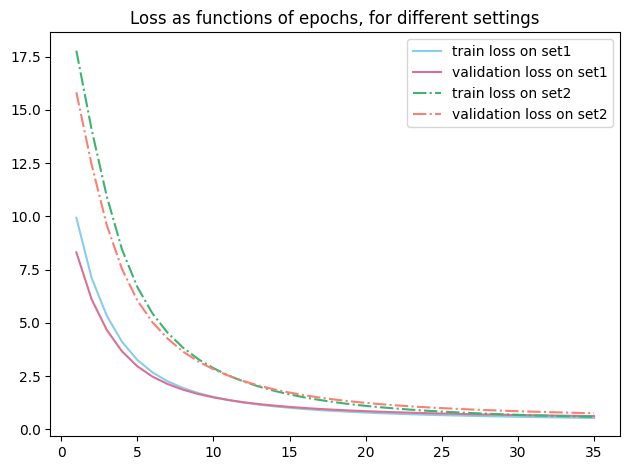

In [25]:
epoch = [i for i in range(1,nb_epochs+1)]

fig, ax = plt.subplots()
ax.plot(epoch, list_train_loss, label='train loss on set1', color='skyblue')
ax.plot(epoch, list_val_loss, label='validation loss on set1', color='palevioletred')
ax.plot(epoch, list_train_loss_comp, label='train loss on set2', color='mediumseagreen', linestyle='dashdot')
ax.plot(epoch, list_val_loss_comp, label='validation loss on set2', color='salmon', linestyle='dashdot')


lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper right')
plt.title('Loss as functions of epochs, for different settings')

fig.tight_layout()
plt.show()